In [4]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
import matplotlib.tri as tri
from scipy.special import betaln
from scipy.stats import beta
from scipy import stats
from scipy.special import gamma as gamma_fun
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
np.set_printoptions(suppress=True)


from deep_bayes.models import DeepEvidentialModel
from deep_bayes.settings import EVIDENTIAL_GAUSSIAN
from deep_bayes.training import train_online
from deep_bayes.losses import log_loss
from deep_bayes.diagnostics import accuracy, expected_calibration_error
from deep_bayes.viz import plot_model_samples, plot_confusion_matrix

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\tensorflow\python\framework\dtypes.

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
tf.enable_eager_execution()

In [7]:
%matplotlib inline

# Generative model specifications

## Model prior 
<p>Defines the prior probabilities over models $p(\boldsymbol{m})$.</p>

In [8]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    n_models   : int  -- the number of generative models in queston
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

## Data generator

In [9]:
def data_generator(batch_size, model_prior, param_priors, forward_models, alpha_smooth=None,
                   n_obs=None, n_obs_min=100, n_obs_max=500, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size     : int -- the number of samples to draw from the prior
    model_prior    : callable -- the prior which returns a sample of model indices
    param_priors   : list of callables -- a list with model prior samplers
    forward_models : list of generative models g(theta) -- a list of generatibve models
    n_obs          : int -- the numebr of observations to draw from p(x|theta)
    n_obs_min      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    n_obs_max      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    to_tensor      : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    m     : tf.Tensor or np.ndarray of shape (batch_size, n_models) - the one-hot encoded version of the models
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from model prior
    # m_indices is an np.int32 array of model indices  
    n_models = len(forward_models)
    m_indices = model_prior(batch_size, n_models)
    
    # Sample N, if not specified
    if n_obs is None:
        n_obs = np.random.randint(low=n_obs_min, high=n_obs_max+1)
    
    # For each model index, sample from prior and run generative model.
    x = []
    theta = []
    for m_idx in m_indices:
        
        # Draw from model prior theta ~ p(theta|
        theta_m = param_priors[m_idx]()
        
        # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
        x_m = forward_models[m_idx](theta_m, n_obs)
        
        # Store data and params
        x.append(x_m)
        theta.append(theta_m)
    
    # One-hot encode model indices
    m = to_categorical(m_indices, num_classes=n_models)
    
    # Apply label smoothing, if specified
    if alpha_smooth is not None:
        m = m * (1 - alpha_smooth) + alpha_smooth / n_models
    
    # Convert to tensor, if specified 
    if to_tensor:
        theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        m = tf.convert_to_tensor(m, dtype=tf.float32)
    return {'m': m, 'theta': theta, 'x': x}

## GMM Setup

In [21]:
def forward_model(theta, n_obs, mu):
    """
    Generates n_obs samples from a 2D GMM.
    """
    
    I = np.random.multinomial(1, pvals=theta, size=n_obs)
    means = mu[I.argmax(1)]
    x = np.random.normal(means)
    return x


ps = [0.5, 0.5]
nx, ny = (20, 20)
x1 = np.linspace(-10, 0, nx)
y1 = np.linspace(-10, 0, ny)
xv1, yv1 = np.meshgrid(x1, y1)


x2 = np.linspace(0, 5, nx)
y2 = np.linspace(0, 5, ny)
xv2, yv2 = np.meshgrid(x2, y2)

mus = []

for i in range(20):
    for j in range(20):
        mus.append( np.array([[xv1[i, j], yv1[i, j]], [xv2[i, j], yv2[i, j]]]))
        
param_priors = [lambda: np.random.dirichlet([30, 30]) for _ in range(400)]
forward_models = [partial(forward_model, mu=mus[i]) for i in range(400)]

# Training hyperparameters (fixed N)

In [22]:
#--- Training hyperparameters ---#
n_obs_min = 50
n_obs_max = 500
n_test = 5000
alpha_smooth = None
epochs = 50
iterations_per_epoch = 1000
batch_size = 128
ckpt_file = 'toy_gaussian'

#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.0001
decay_steps = 1000
decay_rate = .95

#--- Data generation ---#
model_names = ['{}'.format(i) for i in range(1, 401)]
data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs_min=n_obs_min,
                   n_obs_max=n_obs_max,
                   alpha_smooth=alpha_smooth)


# --- Optimizer --- #
global_step = tfe.Variable(0, dtype=tf.int32)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Create test data and compute true BFs

In [23]:
%%time
test_data = data_gen(n_test, n_obs=500)

Wall time: 4.26 s


## Create model

In [24]:
model = DeepEvidentialModel(EVIDENTIAL_GAUSSIAN)

## Manage checkpoints

In [25]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


## Train network

In [ ]:
# Train current model
for ep in range(1, epochs + 1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=partial(log_loss, lambd=0), 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              global_step=global_step,
                              method='evidence')
        
        # Plot stuff
        m_pred = tf.concat([model(x)['m_probs'] for x in tf.split(test_data['x'], 20, axis=0)], axis=0)
        print(accuracy(test_data['m'], m_pred))
#         plot_confusion_matrix(m_pred.numpy().argmax(axis=1), test_data['m'], 
#                               model_names, figsize=(14,6),annotate=False, normalize=True)        
        manager.save()

0.4094



0.483



0.5492
Instructions for updating:
Use standard file APIs to delete files with this prefix.



0.5474



0.5426



0.5482



0.5094



0.4214


## Evaluate

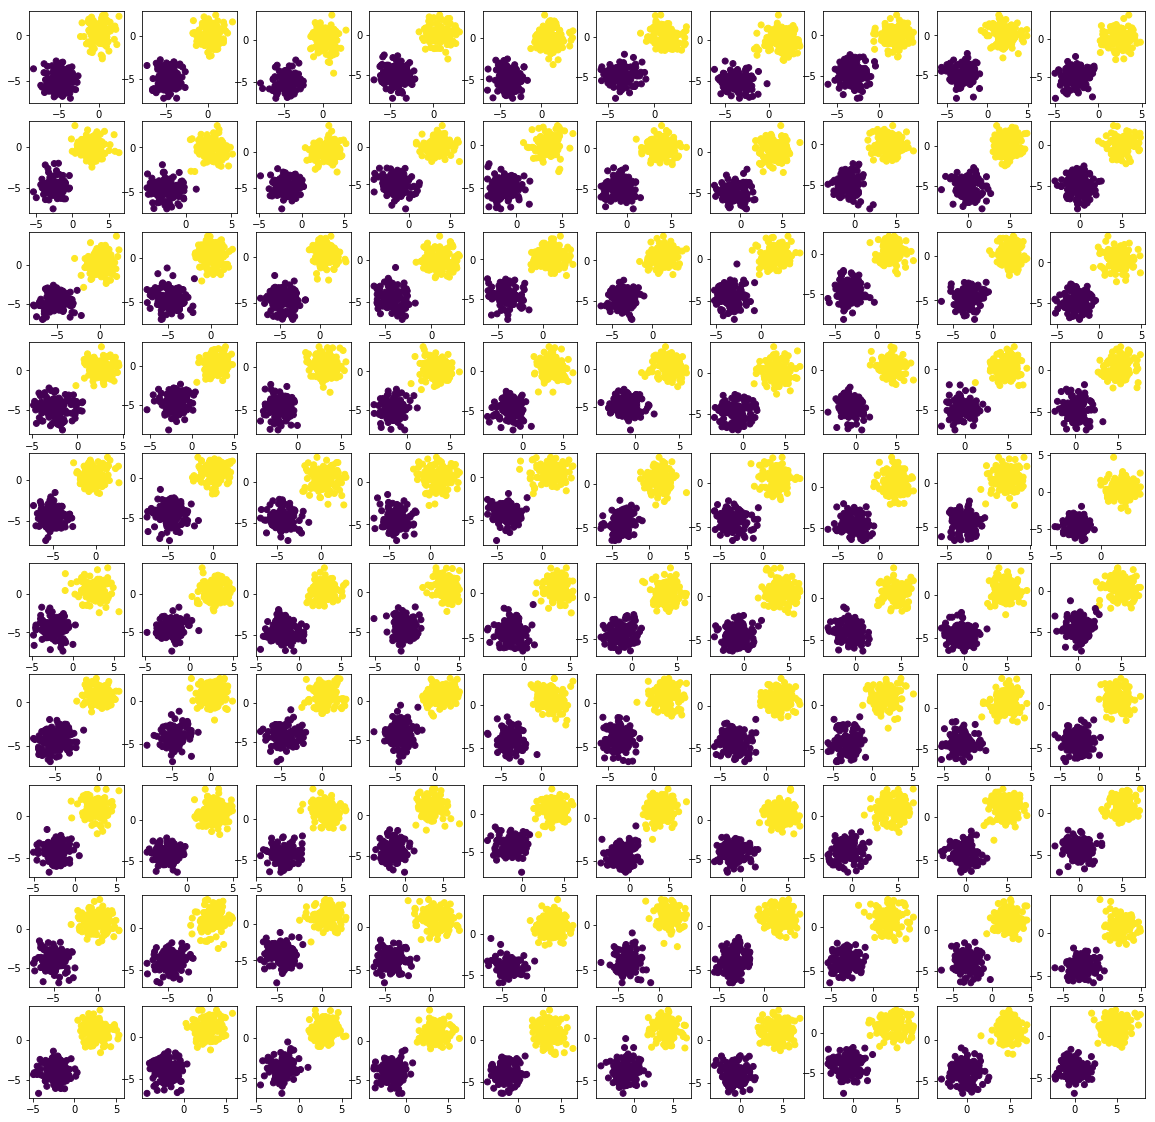

In [109]:
f, axarr = plt.subplots(10, 10, figsize=(20, 20))

for i, ax in enumerate(axarr.flat):
    

    # 2D Gaussian Mixture with 3 clusters
    ps = [0.5, 0.5]
    I = np.random.multinomial(1, pvals=ps, size=250)
    m = mus[i]
    means = m[I.argmax(1)]
    x = np.random.normal(means)
    
    ax.scatter(x[:, 0], x[:, 1], c=I.argmax(1))